#### Pipeline building

In [2]:
from astropy.io import ascii
from Clustering_module import *
from astropy import units as u
from astropy.io import fits
import matplotlib as mpl
import emcee
import corner

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

# def make_rand_from_dist(red_col, n_samples):            #Make a random z distribution from the data z distribution
#     bins = [2.90 + i*0.005 for i in range(500)]         #using inverse transform sampling
#     hist, edges = np.histogram(red_col, bins=bins)
#     bin_widths = np.diff(edges)
#     cdf = np.cumsum(hist * bin_widths) / np.sum(hist * bin_widths)
#     #plt.stairs(cdf, bins)

#     # Generate new z values that follow the histogram distribution
#     uniform_values = np.random.rand(n_samples)
#     bin_indices = np.searchsorted(cdf, uniform_values)
#     bin_edges = edges[bin_indices-1]
#     bin_diff = edges[bin_indices] - edges[bin_indices-1]
#     bin_weights = (uniform_values - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])

#     new_z_values = bin_edges + bin_weights * bin_diff

#     return new_z_values

def make_shen_random_catalog_v3(ra_col, dec_col, red_col, init_level, mult):
    ### First made a random distribution of points in the whole sky, then chose
    ### only those points that fall in the SDSS map 
    num_quasars = len(ra_col) * mult

    nside2 = 2 ** (init_level+1)
    nside3 = 2 ** (init_level+3)
    nside4 = 2 ** (init_level+4)
    nside5 = 2 ** (init_level+6)

    npixels = hp.nside2npix(nside2)
    hp_map = np.zeros(npixels)

    occ_pix_high = hp.ang2pix(nside2, ra_col, dec_col, lonlat=True)
    hp_map[occ_pix_high] = 1
    hp_map = hp.ud_grade(hp_map, nside3)
    occ_pix_high = np.where(hp_map == 1)

    occ_pix_high = np.unique(hp.get_all_neighbours(nside3, occ_pix_high))
    occ_pix_high = np.delete(occ_pix_high, np.where(occ_pix_high == -1))
    hp_map[occ_pix_high] = 1
    hp_map = hp.ud_grade(hp_map, nside4)
    occ_pix_high = np.where(hp_map == 1)

    occ_pix_high = np.unique(hp.get_all_neighbours(nside4, occ_pix_high))
    occ_pix_high = np.delete(occ_pix_high, np.where(occ_pix_high == -1))
    hp_map[occ_pix_high] = 1
    hp_map = hp.ud_grade(hp_map, nside5)
    occ_pix_high = np.where(hp_map == 1)

    occ_pix_high = np.unique(hp.get_all_neighbours(nside5, occ_pix_high))
    occ_pix_high = np.delete(occ_pix_high, np.where(occ_pix_high == -1))
    hp_map[occ_pix_high] = 1

    # map_now = healpix_sky_map_ps1_cover_area(ra_col, dec_col, init_level)
    # map_now = map_now[1]
    map_now = hp_map
    nside = hp.get_nside(map_now)

    pixels_with_data = np.shape(np.where(map_now == 1))[1]
    area_data_pixels = pixels_with_data * hp.nside2pixarea(hp.get_nside(map_now), degrees=True)
    print("Mask area = ", area_data_pixels)

    ind = np.where(np.arange(num_quasars) > -1)
    rand_ra = np.zeros(num_quasars)
    rand_dec = np.zeros(num_quasars)

    while True:
        rand_ra[ind] = np.random.uniform(0, 360, len(ind[0]))
        rand_dec[ind] = np.degrees(np.arcsin(np.random.uniform(-0.5, 1, len(ind[0]))))     

        pix_of_points = hp.ang2pix(nside, np.absolute(np.radians(rand_dec) - np.pi/2), np.radians(rand_ra))
        ind = np.where(map_now[pix_of_points] == 0)

        if(len(ind[0]) == 0):
            break 

    rand_red = make_rand_from_dist(red_col, num_quasars)

    return rand_ra, rand_dec, rand_red

def make_shen_random_catalog_v2(ra_col, dec_col, red_col, init_level, mult):
    ### First made a random distribution of points in the whole sky, then chose
    ### only those points that fall in the SDSS map 
    num_quasars = len(ra_col) * mult

    nside = 2 ** init_level

    map_now = healpix_sky_map_ps1_cover_area(ra_col, dec_col, init_level)
    map_now = map_now[1]

    ind = np.where(np.arange(num_quasars) > -1)
    rand_ra = np.zeros(num_quasars)
    rand_dec = np.zeros(num_quasars)

    while True:
        rand_ra[ind] = np.random.uniform(0, 360, len(ind[0]))
        rand_dec[ind] = np.degrees(np.arcsin(np.random.uniform(-0.5, 1, len(ind[0]))))     

        pix_of_points = hp.ang2pix(nside, np.absolute(np.radians(rand_dec) - np.pi/2), np.radians(rand_ra))
        ind = np.where(map_now[pix_of_points] == 0)

        if(len(ind[0]) == 0):
            break 

    rand_red = make_rand_from_dist(red_col, num_quasars)

    return rand_ra, rand_dec, rand_red

def make_shen_random_catalog(ra_col, dec_col, red_col, init_level, resol_upgrd, mult):
    ### Healpy pixelated the data catalog to find the rough footprint, appropriate healpy level found
    ### from the graph of coverage area vs level. Then increased the pixelation and chosen random
    ### pixels to assign points to its centre.
    ### 
    num_quasars = len(ra_col) * mult

    map_now = healpix_sky_map_ps1_cover_area(ra_col, dec_col, init_level)
    map_now = map_now[1]

    map_then = hp.pixelfunc.ud_grade(map_now, 2 ** resol_upgrd)

    map_random = np.zeros_like(map_then)
    val_pos = np.where(map_then != 0)
    num_pix = len(val_pos[0])

    rand = np.random.randint(0, num_pix, num_quasars)
    rand_pos = val_pos[0][rand]
    map_random[rand_pos] = 1

    rand_ang = hp.pixelfunc.pix2ang(2**resol_upgrd, rand_pos, lonlat=True)

    rand_ra_col = rand_ang[0]
    rand_dec_col = rand_ang[1]

    rand_red_col = make_rand_from_dist(red_col, num_quasars)
    #plt.close()

    return rand_ra_col, rand_dec_col, rand_red_col

def plot_red_dist(red_col, rand_red_col, bins, draw_ax, den=False):
    red_col_shen = red_col
    rand_red_col_shen = rand_red_col

    hist, edges = np.histogram(red_col_shen, bins=bins)
    hist_good, edges_good = np.histogram(red_col_shen_good, bins=bins)

    hist_rand, edges_rand = np.histogram(rand_red_col_shen, bins=bins)

    #print(edges)
    if (den==False):
        hist = hist/np.max(hist)
        hist_good = hist_good/np.max(hist_good)
        hist_rand = hist_rand/np.max(hist_rand)

        ax_fin_cl1 = draw_ax
        ax_fin_cl1.stairs(hist, edges, label="all fields")
        #ax_fin_cl1.stairs(hist_good, edges, label="good field only")
        ax_fin_cl1.stairs(hist_rand, edges, label="random cat")
        ax_fin_cl1.set_xlabel('z')
        ax_fin_cl1.set_ylabel('Distribution')
        ax_fin_cl1.legend()
    else :
        ax_fin_cl1 = draw_ax
        ax_fin_cl1.hist(red_col_shen, bins=bins, histtype='step', density=True, label="all fields")
        #ax_fin_cl1.stairs(hist_good, edges, label="good field only")
        ax_fin_cl1.hist(rand_red_col_shen, bins=bins, histtype='step', density=True, label="random cat")
        ax_fin_cl1.set_xlabel('z')
        ax_fin_cl1.set_ylabel('Distribution')
        ax_fin_cl1.legend()

def make_rand_from_dist(red_col, n_samples):            #Make a random z distribution from the data z distribution
    bins = [2.90 + i*0.005 for i in range(500)]         #using inverse transform sampling
    hist, edges = np.histogram(red_col, bins=bins)
    bin_widths = np.diff(edges)
    cdf = np.cumsum(hist * bin_widths) / np.sum(hist * bin_widths)
    #plt.stairs(cdf, bins)

    # Generate new z values that follow the histogram distribution
    uniform_values = np.random.rand(n_samples)
    bin_indices = np.searchsorted(cdf, uniform_values)
    bin_edges = edges[bin_indices-1]
    bin_diff = edges[bin_indices] - edges[bin_indices-1]
    bin_weights = (uniform_values - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])

    new_z_values = bin_edges + bin_weights * bin_diff

    ##---------------------------------------------
    ## Making changes to see how clustering changes
    #new_z_values = np.random.uniform(2.9, 3.5, n_samples)
    #new_z_values[300:] = new_z_values[300:] * 1.01
    ##

    return new_z_values


def try_clustering_for_z_dist(rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen):
    mpl.rcParams['font.size'] = 18.0
    #-------------------------------------------------------------

    bins = [2.901 + i*0.05 for i in range(50)]
    # fig_fin_cl, (ax_fin_cl1, ax_fin_cl2) = plt.subplots(1, 2, figsize=(12,5))
    fig_fin_cl, ax_fin_cl2 = plt.subplots(figsize=(7,7))
    # plot_red_dist(red_col_shen, rand_red_col_shen, bins, ax_fin_cl1, den=True)

    #-------------------------------------------------------------

    s_bins = np.logspace(start=np.log10(1.9868), stop=np.log10(314.915), num=23)
    s_mid = (s_bins[:-1] + s_bins[1:])/2

    original = ma.masked_values([0, 0, 0, 16.5, 0, 3.54, 1.26, 0.663, 0.191, 0.131, 0.236, -0.280, 0.361, 0.101, 0.0384, 0.0368, 0.0101, 0.0194, -0.00396, 0.0101, -0.00296, 0.00214], 0)
    original_error = ma.masked_values([0, 0, 0, 12.8, 0, 3.61, 1.88, 0.733, 0.786, 0.472, 0.175, 0.223, 0.170, 0.121, 0.0862, 0.0644, 0.0382, \
                                       0.0250, 0.0219, 0.0134, 0.00672, 0.00953], 0)

    fit_clust = pow(s_mid/ 10.2, -1.71)

    ax_fin_cl2.plot(s_mid, fit_clust, '--', label="Shen fit")
    ax_fin_cl2.errorbar(s_mid*np.power(10, 0.02), original, original_error, fmt='r*', capsize=5, label="Shen data")

    #----------------------------------------------------------------

    find_xi_s(ra_col_shen, dec_col_shen, red_col_shen, s_bins, "shen_redshift_space_corr_table_real_signal",\
                        rand_ra=rand_ra_col_shen, rand_dec=rand_dec_col_shen, rand_red=rand_red_col_shen, draw_ax=ax_fin_cl2)

    ax_fin_cl2.legend()


### Obtaining the data catalog from table given in Shen et al 2007
shen_file_name = DP2_DIRECTORY + "Data/shen_quasar_sample_datafile1.txt"
shen_data = ascii.read(shen_file_name)
sub_flag = shen_data.columns[8]
good_flag = shen_data.columns[9]
pos = np.where(sub_flag == 1)
pos_good = np.where(good_flag == 1)
ra_col_shen = shen_data.columns[3][pos].value
dec_col_shen = shen_data.columns[4][pos].value
red_col_shen = shen_data.columns[5][pos].value
imag_col_shen = shen_data.columns[7][pos].value

ra_col_shen_good = shen_data.columns[3][pos_good].value
dec_col_shen_good = shen_data.columns[4][pos_good].value
red_col_shen_good = shen_data.columns[5][pos_good].value
imag_col_shen_good = shen_data.columns[7][pos_good].value

## Trying to find clustering from Shen quasar sample

##### Obtaining the Shen quasar sample

There are 4426 quasars in the catalog


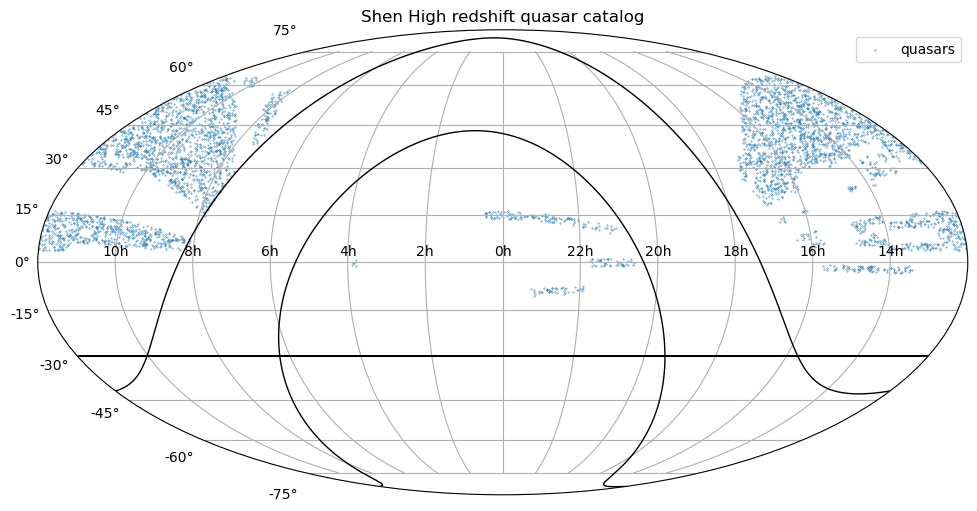

In [2]:
shen_file_name = DP2_DIRECTORY + "Data/shen_quasar_sample_datafile1.txt"
shen_data = ascii.read(shen_file_name)
sub_flag = shen_data.columns[8]
good_flag = shen_data.columns[9]
pos = np.where(sub_flag == 1)
pos_good = np.where(good_flag == 1)
ra_col_shen = shen_data.columns[3][pos].value
dec_col_shen = shen_data.columns[4][pos].value
red_col_shen = shen_data.columns[5][pos].value

ra_col_shen_good = shen_data.columns[3][pos_good].value
dec_col_shen_good = shen_data.columns[4][pos_good].value
red_col_shen_good = shen_data.columns[5][pos_good].value

print("There are {} quasars in the catalog".format(len(ra_col_shen)))
ax = plot_sky_map_ps1(ra_col_shen, dec_col_shen, labels=['quasars'], title="Shen High redshift quasar catalog", mark_size=0.1)

[2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45 3.5  3.55
 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95 4.   4.05 4.1  4.15 4.2  4.25
 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65 4.7  4.75 4.8  4.85 4.9  4.95
 5.   5.05 5.1  5.15 5.2  5.25 5.3  5.35]


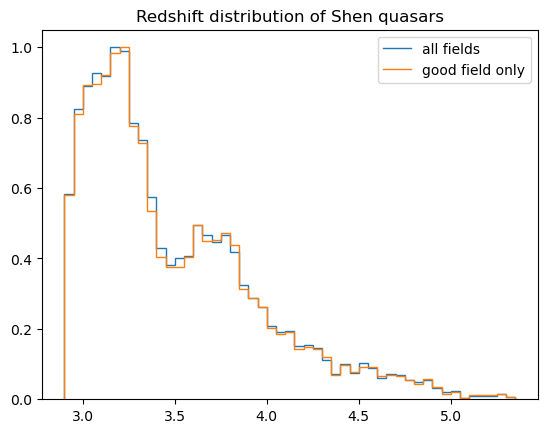

In [2]:
bins = [2.9 + i*0.05 for i in range(50)]
hist, edges = np.histogram(red_col_shen, bins=bins)
hist_good, edges_good = np.histogram(red_col_shen_good, bins=bins)
print(edges)
hist = hist/np.max(hist)
hist_good = hist_good/np.max(hist_good)

plt.stairs(hist, edges, label="all fields")
plt.stairs(hist_good, edges, label="good field only")
plt.title("Redshift distribution of Shen quasars")
plt.legend()

In [ ]:
red_col_shen.max()

##### Finding the footprint

In [ ]:
level = []
cov_area = []
print("Level    coverage area")
for i in [3,4,5,6,7,8,9,10]:
    map_i, wat = healpix_sky_map_ps1_cover_area(ra_col_shen, dec_col_shen, i, title="Level " + str(i))
    level.append(i)
    cov_area.append(map_i)
    print(f'{i:5d}      {map_i:8.5f}')

print(cov_area)
fig, ax = plt.subplots(figsize = (12, 7))
ax.plot(level, cov_area, '*-')
ax.set_title("Effective coverage area versus healpix level for Shen complete quasar sample")
ax.set_xlabel("Level")
ax.set_ylabel("Effective coverage area")

##### Upgrading the footprint finding method

In [ ]:
level = 5
nside1 = 2**level
nside2 = 2**(level + 1)
nside3 = 2**(level + 3)
nside4 = 2**(level + 4)
nside5 = 2**(level + 6)

npixels = hp.nside2npix(nside1)
hp_map = np.zeros(npixels)

ra = ra_col_shen
dec = dec_col_shen

occ_pix = hp.ang2pix(nside1, ra, dec, lonlat=True)
hp_map[occ_pix] = 1
hp_map = hp.ud_grade(hp_map, nside2)

occ_pix_high = hp.ang2pix(nside2, ra, dec, lonlat=True)
hp_map[occ_pix_high] = 0.5
hp_map = hp.ud_grade(hp_map, nside3)
occ_pix_high = np.where(hp_map == 0.5)


occ_pix_high_bound = np.unique(hp.get_all_neighbours(nside3, occ_pix_high))
occ_pix_high_bound = np.delete(occ_pix_high_bound, np.where(occ_pix_high_bound == -1))
hp_map[occ_pix_high_bound] = 0.5
hp_map = hp.ud_grade(hp_map, nside4)
occ_pix_high_bound = np.where(hp_map == 0.5)

occ_pix_high_bound = np.unique(hp.get_all_neighbours(nside4, occ_pix_high_bound))
occ_pix_high_bound = np.delete(occ_pix_high_bound, np.where(occ_pix_high_bound == -1))
hp_map[occ_pix_high_bound] = 0.5
hp_map = hp.ud_grade(hp_map, nside5)
occ_pix_high_bound = np.where(hp_map == 0.5)

occ_pix_high_bound = np.unique(hp.get_all_neighbours(nside5, occ_pix_high_bound))
occ_pix_high_bound = np.delete(occ_pix_high_bound, np.where(occ_pix_high_bound == -1))
hp_map[occ_pix_high_bound] = 0.5

# temp_ra, temp_dec = hp.pix2ang(nside3, occ_pix_high_bound, lonlat=True)
# print(np.where(occ_pix_high_bound == -1))
# occ_pix_high_bound_extra = np.unique(hp.get_all_neighbours(nside3, temp_theta[1:], temp_phi[1:]))

# hp_map = hp.ud_grade(hp_map, nside3)


# hp_map[occ_pix_high_bound_extra] = 0.5

pixels_with_data = np.shape(np.where(hp_map == 0.5))[1]
area_data_pixels = pixels_with_data * hp.nside2pixarea(hp.get_nside(hp_map), degrees=True)
print(area_data_pixels)

hp.mollview(hp_map)

In [ ]:
hp_map_up = np.zeros(hp.nside2npix(hp.get_nside(hp_map)))
hp_map_up[np.where(hp_map == 0.5)] = 1

# nside_big = 2 ** 14
# hp_map_up = hp.ud_grade(hp_map_up, nside_big)

hp.mollview(hp_map_up, title="Best approximation of PS1 footprint")

##### Clustering measurement for the upgraded footprint----- BEST ONE YET

Mask area =  4082.1988880339536


[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?
/home/vibin/MyFolder/WorkDesk/DP2/Codes/Clustering_analysis/Clustering_module.py:299: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  file.write(f'{s_mid[i]:9.3f}   {s_hist[i]:5d}    {rand_s_hist[i]:5d}   {cross_s_hist[i]:5d}   {xi_s_masked[i]:8.5f}   {xi_s_masked_error[i]:8.5f}\n')


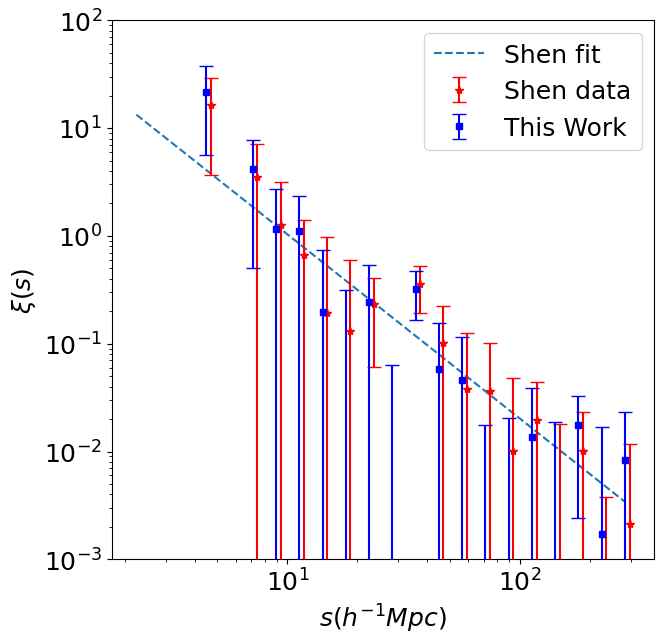

In [2]:
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v3(ra_col_shen, dec_col_shen, red_col_shen, 5, 20)

try_clustering_for_z_dist(rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen)

In [ ]:
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v3(ra_col_shen, dec_col_shen, red_col_shen, 5, 1)
plot_sky_map_ps1(rand_ra_col_shen, rand_dec_col_shen, ['quasars'], title="Random catalog made for shen quasar sample", mark_size=0.1)

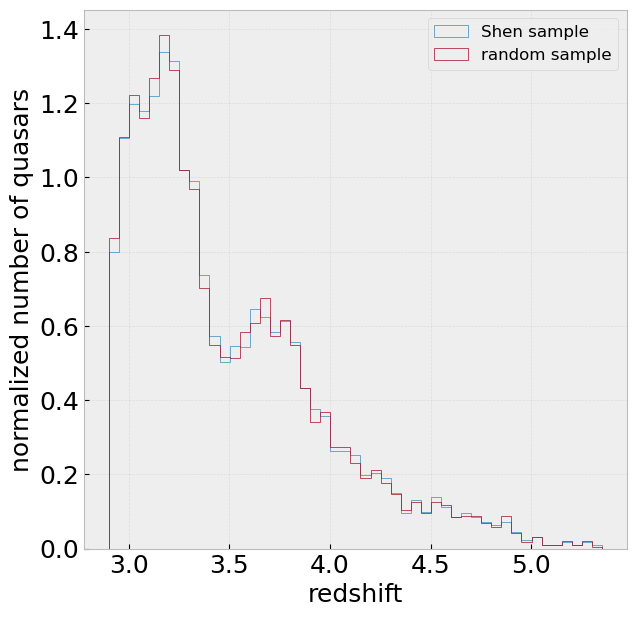

In [5]:
step = 0.05
bins = [2.901 + i*0.05 for i in range(50)]

with plt.style.context('bmh'):
    fig, ax = plt.subplots(figsize=(7,7))
    # hist, bins = np.histogram(red_col_schind_23, bins)
    # hist = hist/np.max(hist)
    ax.hist(red_col_shen, bins, density=True, histtype='step', zorder=10, alpha=1, label = 'Shen sample')
    ax.grid(zorder=1, alpha=0.3)
    ax.set_xlabel('redshift')
    ax.set_ylabel('number density')
    ax.set_aspect('auto')
    plt.rcParams.update({'font.size': 12})

    ax.hist(rand_red_col_shen, bins, density=True, histtype='step', zorder=10, alpha =1, label = 'random sample')
    ax.grid(zorder=1, alpha=0.3)
    ax.set_xlabel('redshift')
    ax.set_ylabel('normalized number of quasars')
    ax.set_aspect('auto')

    plt.legend()

##### Plot: distribution of random catalog

In [7]:
def plot_sky_map_ps1_v2(ra, dec, mask = None, title='', labels=['quasars'], mark_size=30):

    mpl.rcParams['font.size'] = 16

    if (mask == None):
        mask = np.zeros_like(ra, dtype='int')
        mask = np.insert(mask, 0, 1)

    ### Plots the lines marking the excluded area of the galactic plane
    res = 511
    gal_l = np.linspace(0, 360, res)
    gal_b = np.ones(res) * 20.0
    gal_line_1 = SkyCoord(gal_l, gal_b, frame = 'galactic', unit = 'deg')
    gal_line_2 = SkyCoord(gal_l, -gal_b, frame = 'galactic', unit = 'deg')
    ### gal_line_equat is the galactic line in equatorial coordinates
    gal_line_equat_1 = gal_line_1.transform_to('icrs')   
    gal_line_equat_2 = gal_line_2.transform_to('icrs')
    gal_ra_1 = np.radians(range_wrapper(gal_line_equat_1.ra.degree))
    ###Sorting the array in order to do line plot
    i_sorted = np.argsort(gal_ra_1) 
    gal_ra_1 = gal_ra_1[i_sorted]
    gal_dec_1 = np.radians(gal_line_equat_1.dec.degree)[i_sorted]
    gal_ra_2 = np.radians(range_wrapper(gal_line_equat_2.ra.degree))
    i_sorted = np.argsort(gal_ra_2)
    gal_ra_2 = gal_ra_2[i_sorted]
    gal_dec_2 = np.radians(gal_line_equat_2.dec.degree)[i_sorted]
    ### dec -30 array is obtained
    dec_30_ra = np.radians(range_wrapper(np.linspace(0, 360, res)))
    dec_30_dec = np.radians(np.ones(res) * -30.0)

    fig, ax = plt.subplots(figsize = (12, 7), subplot_kw={'projection': 'mollweide'})
    # plt.rcParams.update({'font.size': 12})
    # plt.rc('legend', fontsize=14)
    #ax = plt.subplot(111, projection = "mollweide")

    ### This plots the footprint
    ax.plot(gal_ra_1, gal_dec_1, color = 'black', linestyle='--', linewidth = 1) 
    ax.plot(gal_ra_2, gal_dec_2, color = 'black', linestyle='--', linewidth = 1)
    # ax.plot(dec_30_ra, dec_30_dec, color = 'black', linestyle='-.', linewidth = 1)
    #-------------------------------------------------------------------------------------------
    ### Plotting the sources
    ra = np.radians(range_wrapper(ra)) 
    dec = np.radians(dec)
    marker = ['o','x']

    for n_source in range(mask[0]):
        source_pos = np.where(mask[1:] == n_source)
        ra_n, dec_n = ra[source_pos], dec[source_pos]

        ax.scatter(ra_n, dec_n, marker = marker[n_source], label = labels[n_source], color='navy', alpha=1, s = mark_size, zorder=10)

    foot_ra, foot_dec, foot_red = make_shen_random_catalog_v3(ra_col_shen, dec_col_shen, red_col_shen, 5, 50)
    foot_ra=np.radians(range_wrapper(foot_ra))
    foot_dec = np.radians(foot_dec)
    ax.scatter(foot_ra, foot_dec, color='grey', s=0.1, zorder=2, alpha = 0.05)  

    ax.set_title(title)
    ax.legend()
    ax.grid(True)

    ax.set_xticklabels(["10h", "8h", "6h", "4h", "2h", "0h", "22h", "20h", "18h", "16h", "14h"]);
    #plt.style.use(astropy_mpl_style)

    return ax

# ax = plot_sky_map_ps1_v2(ra_col_shen, dec_col_shen,labels = ['quasars'], title="Shen quasar sample", mark_size=0.5)




Mask area =  4082.1988880339536
Mask area =  4082.1988880339536


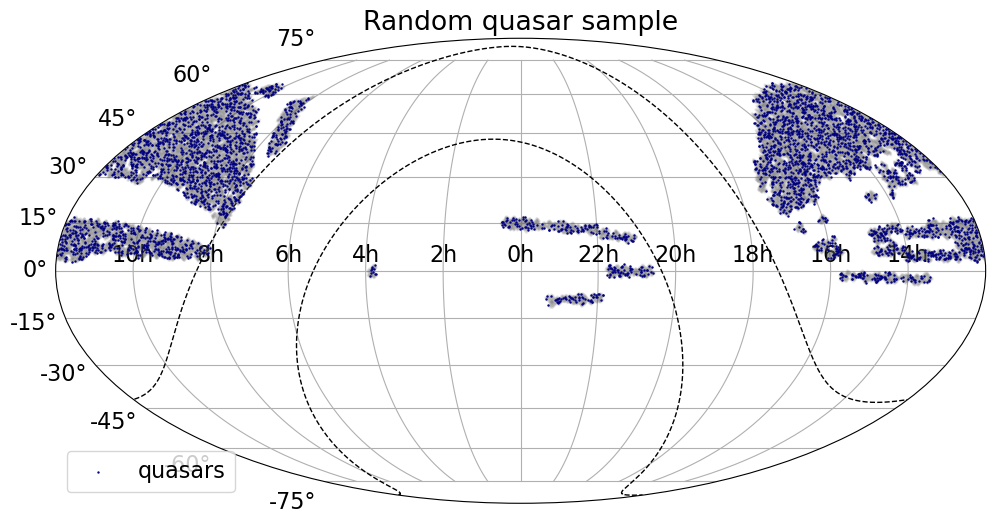

In [8]:
rand_ra, rand_dec, rand_red = make_shen_random_catalog_v3(ra_col_shen, dec_col_shen, red_col_shen, 5, 1)
ax = plot_sky_map_ps1_v2(rand_ra, rand_dec,labels = ['quasars'], title="Random quasar sample", mark_size=0.5)

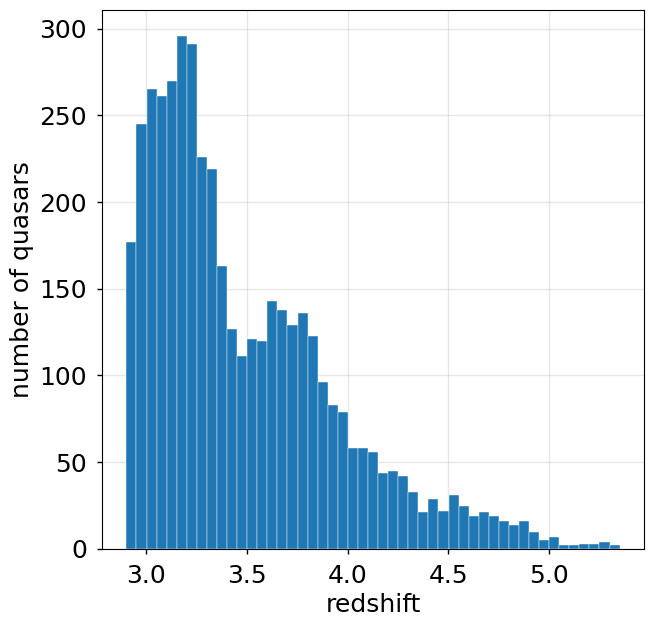

In [4]:
step = 0.05
bins = np.arange(np.min(red_col_shen), np.max(red_col_shen) + step, step)

with plt.style.context('seaborn-v0_8-notebook'):
    mpl.rcParams['xtick.labelsize'] = 'medium'
    mpl.rcParams['ytick.labelsize'] = 'medium'
    mpl.rcParams['font.size'] = 18.0
    fig, ax = plt.subplots( figsize=(7,7))
    # hist, bins = np.histogram(red_col_schind_23, bins)
    # hist = hist/np.max(hist)
    ax.hist(red_col_shen, bins, edgecolor='white', zorder=10)
    ax.grid(zorder=1, alpha=0.3)
    ax.set_xlabel('redshift')
    ax.set_ylabel('number of quasars')
    ax.set_aspect('auto')

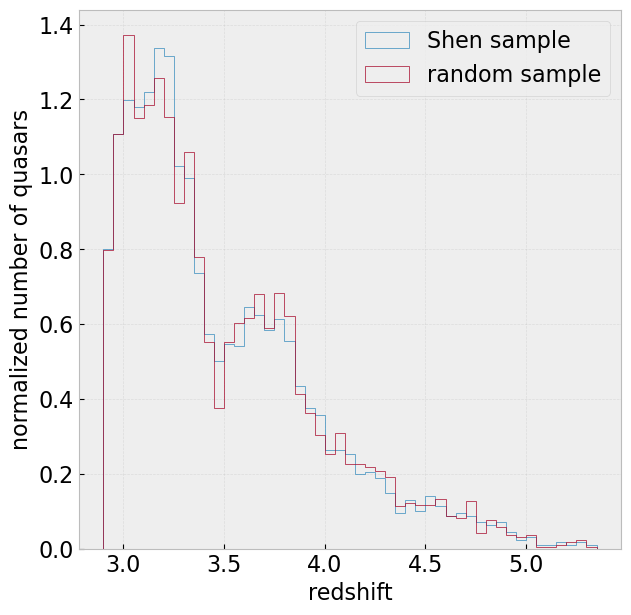

In [9]:
step = 0.05
bins = [2.901 + i*0.05 for i in range(50)]

with plt.style.context('bmh'):
    mpl.rcParams['font.size'] = 16
    fig, ax = plt.subplots(figsize=(7,7))
    # hist, bins = np.histogram(red_col_schind_23, bins)
    # hist = hist/np.max(hist)
    ax.hist(red_col_shen, bins, density=True, histtype='step', zorder=10, alpha=1, label = 'Shen sample')
    ax.grid(zorder=1, alpha=0.3)
    ax.set_xlabel('redshift')
    ax.set_ylabel('number density')
    ax.set_aspect('auto')

    ax.hist(rand_red, bins, density=True, histtype='step', zorder=10, alpha =1, label = 'random sample')
    ax.grid(zorder=1, alpha=0.3)
    ax.set_xlabel('redshift')
    ax.set_ylabel('normalized number of quasars')
    ax.set_aspect('auto')

    plt.legend()

##### Showing our DD pair counts agrees with that of Shen

In [ ]:
s_bins = np.logspace(start=np.log10(1.9868), stop=np.log10(314.915), num=23)
s_mid = (s_bins[:-1] + s_bins[1:])/2

s_array = find_s_bined(ra_col_shen, dec_col_shen, red_col_shen)

s_hist, edges = np.histogram(s_array, s_bins)

In [ ]:
shen_DD_original = np.array([0.0, 0.0, 0.0, 1.8, 0.0, 1.8, 1.8, 2.7, 4.5, 8.9, 15.2, 22.4, 70.7, 104.9, 210.9, 384.8, 734.2, 1417.1, 2565.8, 4821.6, 8631.8, 15365.1])
shen_RR_original = np.array([0.9, 5.4, 6.3, 14.4, 34.2, 38.7, 99.0, 215.0, 406.5, 804.2, 1592.4,\
                              3123.6, 6028.6, 11959.1, 23480.2, 45648.7, 88337.9, 168480.9, 3117727.8, 588892.8, 1070807.1, 1912774.1])
plt.stairs(s_hist, s_bins)
plt.stairs(shen_DD_original, s_bins)
plt.xlabel('s')
plt.ylabel('DD')

print((s_hist - shen_DD_original)/s_hist)

### Trying to make a random catalog for Shen quasars

#### random catalog examples

In [ ]:
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog(ra_col_shen, dec_col_shen, red_col_shen, 5, 11, 2)
plt.close()

plot_sky_map_ps1(rand_ra_col_shen, rand_dec_col_shen, labels=['quasars'], title="Random catalog made for Shen quasar sample", mark_size=0.1)

In [ ]:
### Random catalog making v2

rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v2(ra_col_shen, dec_col_shen, red_col_shen, 5, 1)
plt.close()

plot_sky_map_ps1(rand_ra_col_shen, rand_dec_col_shen, labels=['quasars'], title="Random catalog made for Shen quasar sample", mark_size=0.1)

#### Redshift distribution of the random catalog from inverse tranform sampling

In [ ]:
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog(ra_col_shen, dec_col_shen, red_col_shen, 5, 11, 2)
plt.close()

bins = [2.901 + i*0.05 for i in range(50)]
hist, edges = np.histogram(red_col_shen, bins=bins)
hist_good, edges_good = np.histogram(red_col_shen_good, bins=bins)

hist_rand, edges_rand = np.histogram(rand_red_col_shen, bins=bins)

#print(edges)
hist = hist/np.max(hist)
hist_good = hist_good/np.max(hist_good)
hist_rand = hist_rand/np.max(hist_rand)

plt.stairs(hist, edges, label="all fields")
#plt.stairs(hist_good, edges, label="good field only")
plt.stairs(hist_rand, edges, label="random cat")
plt.xlabel('z')
plt.ylabel('Distribution')
plt.legend()

#### Analysing the random catalog made

In [ ]:
### converting the random catalog to a bunch of x, y and z in comoving coordinates

rand_ra_col, rand_dec_col, rand_red_col = make_shen_random_catalog_v2(ra_col_shen, dec_col_shen, red_col_shen, 5, 12)
plt.close()

s_bins = np.logspace(start=np.log10(1.9868), stop=np.log10(314.915), num=23)

s_hist = (pair_count_corrfunc(ra_col_shen, dec_col_shen, red_col_shen, s_bins)[:,3]).astype(int)
rand_s_hist = (pair_count_corrfunc(rand_ra_col, rand_dec_col, rand_red_col, s_bins)[:,3]).astype(int)
cross_s_hist = (pair_count_corrfunc(ra_col_shen, dec_col_shen, red_col_shen, s_bins, rand_ra_col=rand_ra_col, rand_dec_col=rand_dec_col, rand_red_col=rand_red_col)[:,3]).astype(int) * 2
s_hist_norm = (len(ra_col_shen) * (len(ra_col_shen) - 1))/2
rand_hist_norm = (len(rand_ra_col) * (len(rand_ra_col) - 1))/2
cross_hist_norm = len(ra_col_shen) * len(rand_ra_col)

unfin_pos = np.where(s_hist * rand_s_hist * cross_s_hist == 0)

with np.errstate(divide='ignore', invalid='ignore'):
    xi_s = (s_hist/s_hist_norm - 2 * cross_s_hist/cross_hist_norm + rand_s_hist/rand_hist_norm)/(rand_s_hist/rand_hist_norm)
xi_s_masked = ma.array(xi_s)
xi_s_masked[unfin_pos] = -999

printer = np.array([s_hist, rand_s_hist, cross_s_hist, xi_s_masked]).T
print(printer)
print(rand_hist_norm/s_hist_norm)

# binned_rand = find_s_bined(rand_ra_col, rand_dec_col, rand_red_col)
# hist_rand = np.histogram(binned_rand, s_bins)
# print(hist_rand[0])

##### ----------------------------------------------------------------------------------------------------

#### Best attempt on cluster measurement so far

In [ ]:
# rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog(ra_col_shen, dec_col_shen, red_col_shen, 5, 11, 1)
# plt.close()

def make_rand_from_dist(red_col, n_samples):            #Make a random z distribution from the data z distribution
    bins = [2.90 + i*0.005 for i in range(500)]         #using inverse transform sampling
    hist, edges = np.histogram(red_col, bins=bins)
    print(np.shape(hist))
    bin_widths = np.diff(edges)
    cdf = np.cumsum(hist * bin_widths) / np.sum(hist * bin_widths)
    cdf = np.insert(cdf, 0, 0)
    #plt.stairs(cdf, bins)

    # Generate new z values that follow the histogram distribution
    uniform_values = np.random.rand(n_samples)
    bin_indices = np.searchsorted(cdf, uniform_values)
    bin_edges = edges[bin_indices-1]
    bin_diff = edges[bin_indices] - edges[bin_indices-1]
    bin_weights = (uniform_values - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])

    new_z_values = bin_edges + bin_weights * bin_diff

    ##---------------------------------------------
    ## Making changes to see how clustering changes
    #new_z_values = np.random.uniform(2.9, 3.5, n_samples)
    #new_z_values[300:] = new_z_values[300:] * 1.01
    ##

    return new_z_values

### Trying the clustering with the v2 of random catalog maker
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v2(ra_col_shen, dec_col_shen, red_col_shen, 5, 10)
plt.close()

#-------------------------------------------------------------

bins = [2.901 + i*0.05 for i in range(50)]
fig_fin_cl, (ax_fin_cl1, ax_fin_cl2) = plt.subplots(1, 2, figsize=(12,5))
plot_red_dist(red_col_shen, rand_red_col_shen, bins, ax_fin_cl1)

#-------------------------------------------------------------

s_bins = np.logspace(start=np.log10(1.9868), stop=np.log10(314.915), num=23)
s_mid = (s_bins[:-1] + s_bins[1:])/2

original = ma.masked_values([0, 0, 0, 16.5, 0, 3.54, 1.26, 0.663, 0.191, 0.131, 0.236, 0, 0.361, 0.101, 0.0384, 0.0368, 0.0101, 0.0194, 0, 0.0101, 0, 0.00214], 0)

fit_clust = pow(s_mid/ 10.2, -1.71)

ax_fin_cl2.plot(s_mid, fit_clust, '--', label="Shen fit")
ax_fin_cl2.plot(s_mid, original, 'r*', label="Shen data")

#----------------------------------------------------------------

find_xi_s(ra_col_shen, dec_col_shen, red_col_shen, s_bins, "shen_redshift_space_corr_table_real_signal",\
                     rand_ra=rand_ra_col_shen, rand_dec=rand_dec_col_shen, rand_red=rand_red_col_shen, draw_ax=ax_fin_cl2)

ax_fin_cl2.legend()


#### Trying to find the probability, $P(z)$ of quasars from selection function $S(z)$ and the redshift evolution of density due to expansion of universe $\rho(z) = \rho(0)(1+z)^3$

In [ ]:
sdss_sel_fun_file_name = DP2_DIRECTORY + 'Data/sdss_q_sel_fun_richards.dat'
sdss_sel_fun_file = open(sdss_sel_fun_file_name, 'r')
sdss_sel_fun = np.genfromtxt(sdss_sel_fun_file)

sel_fun_imag_col = sdss_sel_fun[:,0]
sel_fun_z_col = sdss_sel_fun[:,1]
sel_fun_point_col = sdss_sel_fun[:,2]
sel_fun_radio_col = sdss_sel_fun[:,3]
sel_fun_extended_col = sdss_sel_fun[:,4]

### selection function is given in the following way: 53 i magnitudes are there from 15.0 to 20.2, difference of 0.1, for each magnitude 121 z values 
# from 0.0 to 6.0 is given with difference of 0.05.

sel_fun_z = sel_fun_z_col[0:121] ### this is the z values where we have the S(z)
sel_fun_imag = np.reshape(sel_fun_imag_col, (53,121))[:,0]
sel_fun_point_val = np.sum(np.reshape(sel_fun_point_col,(53, 121)), axis=0) * 0.1
sel_fun_point_grid = np.reshape(sel_fun_point_col,(53, 121))
sel_fun_radio_val = np.sum(np.reshape(sel_fun_radio_col,(53, 121)), axis=0) * 0.1
sel_fun_ext_val = np.sum(np.reshape(sel_fun_extended_col,(53, 121)), axis=0) * 0.1

loc_29_54 = np.where((sel_fun_z >= 2.9) & (sel_fun_z <= 5.4))
sel_fun_z_act= sel_fun_z[loc_29_54][1:-1]
sel_fun_z_bins = (sel_fun_z[loc_29_54] - 0.05/2)[1:]
sel_fun_point_act = (sel_fun_point_val[loc_29_54])[1:-1]

In [ ]:
numerator = np.power(1 + sel_fun_z_act, 3) * sel_fun_point_act
denominator = np.sum(numerator) * 0.1
pz = numerator/denominator
numerator.shape

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10)) #, sharex=True, sharey=True)
ax1.plot(sel_fun_z_act, sel_fun_point_act)
ax1.set_title('selection function')
ax2.plot(sel_fun_z_act, np.power(1+sel_fun_z_act, 3))
ax2.set_title(r'$(1 + z)^3$')
ax3.plot(sel_fun_z_act, numerator)
ax3.set_title('unnormalised P(z)')
ax4.plot(sel_fun_z_act, pz)
ax4.set_title('normalised P(z)')
ax3.set_xlabel('z')

plt.show()

In [ ]:
def make_rand_from_pz(pz, bins, n_samples):
    hist, edges = pz, bins
    bin_widths = np.diff(edges)
    cdf = np.cumsum(hist * bin_widths) / np.sum(hist * bin_widths)
    #plt.stairs(cdf, bins)

    # Generate new z values that follow the histogram distribution
    uniform_values = np.random.rand(n_samples)
    bin_indices = np.searchsorted(cdf, uniform_values)
    bin_edges = edges[bin_indices-1]
    bin_diff = edges[bin_indices] - edges[bin_indices-1]
    bin_weights = (uniform_values - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])

    new_z_values = bin_edges + bin_weights * bin_diff

    return new_z_values


In [ ]:
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v2(ra_col_shen, dec_col_shen, red_col_shen, 5, 10)
plt.close()
rand_red_col_shen = make_rand_from_pz(pz, sel_fun_z_bins, len(rand_ra_col_shen))

#-------------------------------------------------------------

bins = [2.901 + i*0.05 for i in range(50)]
fig_fin_cl, (ax_fin_cl1, ax_fin_cl2) = plt.subplots(1, 2, figsize=(12,5))
plot_red_dist(red_col_shen, rand_red_col_shen, bins, ax_fin_cl1)

#-------------------------------------------------------------

s_bins = np.logspace(start=np.log10(1.9868), stop=np.log10(314.915), num=23)
s_mid = (s_bins[:-1] + s_bins[1:])/2

original = ma.masked_values([0, 0, 0, 16.5, 0, 3.54, 1.26, 0.663, 0.191, 0.131, 0.236, 0, 0.361, 0.101, 0.0384, 0.0368, 0.0101, 0.0194, 0, 0.0101, 0, 0.00214], 0)

fit_clust = pow(s_mid/ 10.2, -1.71)

ax_fin_cl2.plot(s_mid, fit_clust, '--', label="Shen fit")
ax_fin_cl2.plot(s_mid, original, 'r*', label="Shen data")

#----------------------------------------------------------------

find_xi_s(ra_col_shen, dec_col_shen, red_col_shen, s_bins, "shen_redshift_space_corr_table_real_signal",\
                     rand_ra=rand_ra_col_shen, rand_dec=rand_dec_col_shen, rand_red=rand_red_col_shen, draw_ax=ax_fin_cl2)

ax_fin_cl2.legend()

#### Trial and error to see how the clustering measure differs with redshift distribution

In [ ]:
def make_rand_from_dist(red_col, n_samples):            #Make a random z distribution from the data z distribution
    bins = [2.90 + i*0.0005 for i in range(5000)]         #using inverse transform sampling
    hist, edges = np.histogram(red_col, bins=bins)
    
    print(hist)
    #hist[np.where(hist < 5)] = hist[np.where(hist < 5)] - 0

    bin_widths = np.diff(edges)
    cdf = np.cumsum(hist * bin_widths) / np.sum(hist * bin_widths)
    #plt.stairs(cdf, bins)

    # Generate new z values that follow the histogram distribution
    uniform_values = np.random.rand(n_samples)
    bin_indices = np.searchsorted(cdf, uniform_values)
    bin_edges = edges[bin_indices-1]
    bin_diff = edges[bin_indices] - edges[bin_indices-1]
    bin_weights = (uniform_values - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])

    new_z_values = bin_edges + bin_weights * bin_diff

    ##---------------------------------------------
    ## Making changes to see how clustering changes
    #new_z_values = np.random.uniform(2.9, 3.5, n_samples)
    #new_z_values[300:] = new_z_values[300:] * 1.01
    ##

    return new_z_values

### Trying the clustering with the v2 of random catalog maker
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v2(ra_col_shen, dec_col_shen, red_col_shen, 5, 10)
plt.close()

#-------------------------------------------------------------

bins = [2.901 + i*0.05 for i in range(50)]
fig_fin_cl, (ax_fin_cl1, ax_fin_cl2) = plt.subplots(1, 2, figsize=(12,5))
# plot_red_dist(red_col_shen, rand_red_col_shen, bins, ax_fin_cl1)
ax_fin_cl1.hist(red_col_shen, bins, histtype='step', density=True)
ax_fin_cl1.hist(rand_red_col_shen, bins, histtype='step', density=True)

#-------------------------------------------------------------

s_bins = np.logspace(start=np.log10(1.9868), stop=np.log10(314.915), num=23)
s_mid = (s_bins[:-1] + s_bins[1:])/2

original = ma.masked_values([0, 0, 0, 16.5, 0, 3.54, 1.26, 0.663, 0.191, 0.131, 0.236, 0, 0.361, 0.101, 0.0384, 0.0368, 0.0101, 0.0194, 0, 0.0101, 0, 0.00214], 0)

fit_clust = pow(s_mid/ 10.2, -1.71)

ax_fin_cl2.plot(s_mid, fit_clust, '--', label="Shen fit")
ax_fin_cl2.plot(s_mid, original, 'r*', label="Shen data")

#----------------------------------------------------------------

find_xi_s(ra_col_shen, dec_col_shen, red_col_shen, s_bins, "shen_redshift_space_corr_table_real_signal",\
                     rand_ra=rand_ra_col_shen, rand_dec=rand_dec_col_shen, rand_red=rand_red_col_shen, draw_ax=ax_fin_cl2)

ax_fin_cl2.legend()


#### Dealing with the quasar selection function as given in Richards et al 2006.

In [35]:
sdss_sel_fun_file_name = DP2_DIRECTORY + 'Data/sdss_q_sel_fun_richards.dat'
sdss_sel_fun_file = open(sdss_sel_fun_file_name, 'r')
sdss_sel_fun = np.genfromtxt(sdss_sel_fun_file)

sel_fun_imag_col = sdss_sel_fun[:,0]
sel_fun_z_col = sdss_sel_fun[:,1]
sel_fun_point_col = sdss_sel_fun[:,2]
sel_fun_radio_col = sdss_sel_fun[:,3]
sel_fun_extended_col = sdss_sel_fun[:,4]

### selection function is given in the following way: 53 i magnitudes are there from 15.0 to 20.2, difference of 0.1, for each magnitude 121 z values 
# from 0.0 to 6.0 is given with difference of 0.05.

sel_fun_z = sel_fun_z_col[0:121]
sel_fun_imag = np.reshape(sel_fun_imag_col, (53,121))[:,0]
sel_fun_point_val = np.sum(np.reshape(sel_fun_point_col,(53, 121)), axis=0) * 0.1
sel_fun_point_grid = np.reshape(sel_fun_point_col,(53, 121))
sel_fun_radio_val = np.sum(np.reshape(sel_fun_radio_col,(53, 121)), axis=0) * 0.1
sel_fun_ext_val = np.sum(np.reshape(sel_fun_extended_col,(53, 121)), axis=0) * 0.1

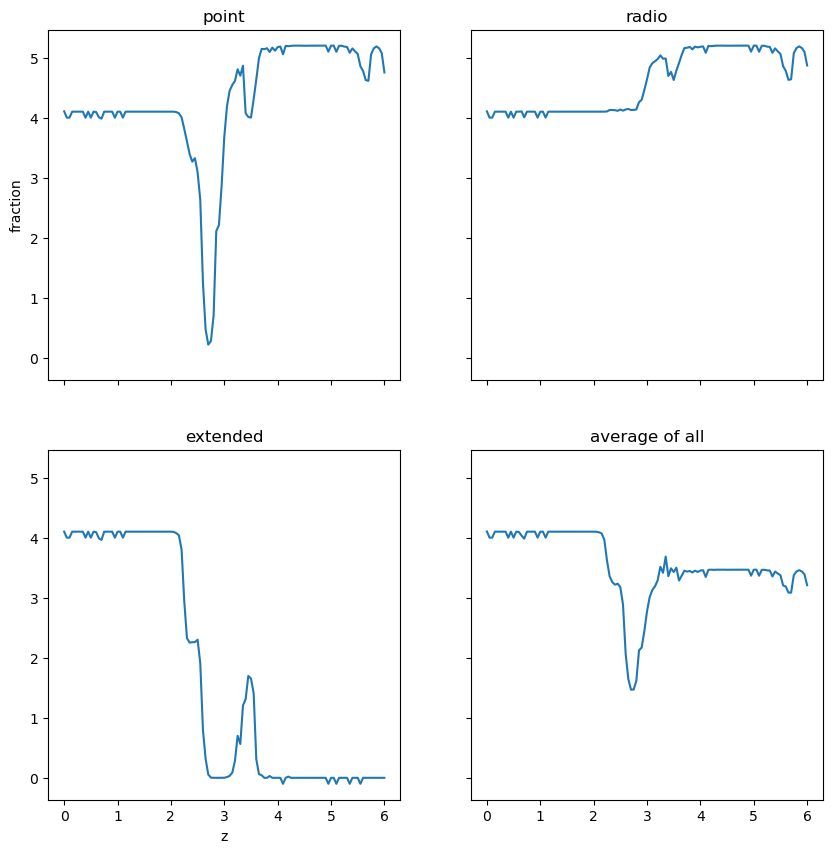

In [36]:
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
ax1.plot(sel_fun_z, sel_fun_point_val)
ax1.set_title('point')
ax2.plot(sel_fun_z, sel_fun_radio_val)
ax2.set_title('radio')
ax3.plot(sel_fun_z, sel_fun_ext_val)
ax3.set_title('extended')
ax4.plot(sel_fun_z, (sel_fun_point_val + sel_fun_radio_val + sel_fun_ext_val)/3)
ax4.set_title('average of all')
ax3.set_xlabel('z')
ax1.set_ylabel('fraction')
plt.show()

In [ ]:
loc_z = (sel_fun_z >= 2.9) & (sel_fun_z <= 5.4)
sel_fun_point_grid_real = sel_fun_point_grid[:,loc_z].T
sel_fun_z_real = sel_fun_z[loc_z]

im_sel = plt.imshow(sel_fun_point_grid_real.T, extent=[sel_fun_z_real.min(), sel_fun_z_real.max(), sel_fun_imag.max(), sel_fun_imag.min()], aspect='auto', vmin=0)
plt.colorbar(im_sel)

In [ ]:
sel_fun_point_grid_real.shape

##### QLF from Richards et al 2006

In [ ]:
from astropy.cosmology import LambdaCDM as LCDM
cosmo = LCDM(H0=70, Om0=0.3, Ode0=0.7)  ## they could have calculated luminosity distance differently
d_z2 = cosmo.luminosity_distance(z=2)

def QLF_phi_app(m, z, **kwargs):
    M_z2 = m - 5 * np.log10(cosmo.luminosity_distance(z=4)/(1E-5 * u.Mpc))
    phi_ast = pow(10, kwargs['log_phi_ast'])
    zeta = np.log10((1+z)/(1+kwargs['z_ref']))
    mu = M_z2 - (kwargs['M_ast'] + kwargs['B1']*zeta + kwargs['B2']*pow(zeta,2) + kwargs['B3']*pow(zeta,3))
    phi = phi_ast * pow(10, mu* (kwargs['A1'] + kwargs['A2'] * (z - 2.45)))

    return phi

def QLF_phi_abs(M, z, **kwargs):
    phi_ast = pow(10, kwargs['log_phi_ast'])
    zeta = np.log10((1+z)/(1+kwargs['z_ref']))
    mu = M - (kwargs['M_ast'] + kwargs['B1']*zeta + kwargs['B2']*pow(zeta,2) + kwargs['B3']*pow(zeta,3))
    phi = phi_ast * pow(10, mu* (kwargs['A1'] + kwargs['A2'] * (z - 2.45)))

    return phi   


In [ ]:
keywords = {'A1':0.83, 'A2':-0.11, 'B1':1.43, 'B2':36.63, 'B3':34.39, 'M_ast':-26, 'z_ref':2.45, 'log_phi_ast':-5.70}

z_array = np.linspace(0, 5, 100)
phi_array = QLF_phi_app(15, z_array, **keywords)

plt.plot(z_array, phi_array)
plt.yscale('log')

In [ ]:
m_array = sel_fun_imag
z_array = sel_fun_z[(sel_fun_z >= 2.9) & (sel_fun_z <= 5.4)]
m_grid, z_grid = np.meshgrid(m_array, z_array)
phi_array1 = QLF_phi_app(m_grid, z_grid, **keywords)

im = plt.imshow(phi_array1, extent=[z_array.min(), z_array.max(), m_array.min(), m_array.max()], norm='log', aspect='auto')
plt.colorbar(im)

In [ ]:
M_array = np.linspace(-15.0, -20.2, 100)
z_array = np.linspace(2.9, 5.4, 1000)

M_grid, z_grid = np.meshgrid(m_array, z_array)
phi_array2 = QLF_phi_abs(M_grid, z_grid, **keywords)

im1 = plt.imshow(phi_array2, extent=[z_array.min(), z_array.max(), M_array.min(), M_array.max()], norm='log', aspect='auto')
plt.colorbar(im1)

### Making a new random catalog via the QLF with each magnitude bin considered seperately

In [ ]:
from astropy.cosmology import LambdaCDM as LCDM
cosmo = LCDM(H0=70, Om0=0.3, Ode0=0.7)  ## they could have calculated luminosity distance differently
d_z2 = cosmo.luminosity_distance(z=2)

def QLF_phi_app(m, z, **kwargs):
    M_z2 = m - 5 * np.log10(cosmo.luminosity_distance(z=4)/(1E-5 * u.Mpc))
    phi_ast = pow(10, kwargs['log_phi_ast'])
    zeta = np.log10((1+z)/(1+kwargs['z_ref']))
    mu = M_z2 - (kwargs['M_ast'] + kwargs['B1']*zeta + kwargs['B2']*pow(zeta,2) + kwargs['B3']*pow(zeta,3))
    phi = phi_ast * pow(10, mu* (kwargs['A1'] + kwargs['A2'] * (z - 2.45)))

    return phi.value

keywords = {'A1':0.83, 'A2':-0.11, 'B1':1.43, 'B2':36.63, 'B3':34.39, 'M_ast':-26, 'z_ref':2.45, 'log_phi_ast':-5.70}

sdss_sel_fun_file_name = DP2_DIRECTORY + 'Data/sdss_q_sel_fun_richards.dat'
sdss_sel_fun_file = open(sdss_sel_fun_file_name, 'r')
sdss_sel_fun = np.genfromtxt(sdss_sel_fun_file)

sel_fun_imag_col = sdss_sel_fun[:,0]
sel_fun_z_col = sdss_sel_fun[:,1]
sel_fun_point_col = sdss_sel_fun[:,2]
sel_fun_radio_col = sdss_sel_fun[:,3]
sel_fun_extended_col = sdss_sel_fun[:,4]

### selection function is given in the following way: 53 i magnitudes are there from 15.0 to 20.2, difference of 0.1, for each magnitude 121 z values 
# from 0.0 to 6.0 is given with difference of 0.05.

sel_fun_z = sel_fun_z_col[0:121] ### this is the z values where we have the S(z)
sel_fun_imag = np.reshape(sel_fun_imag_col, (53,121))[:,0]
sel_fun_point_val = np.sum(np.reshape(sel_fun_point_col,(53, 121)), axis=0) * 0.1
sel_fun_point_grid = np.reshape(sel_fun_point_col,(53, 121))
sel_fun_radio_val = np.sum(np.reshape(sel_fun_radio_col,(53, 121)), axis=0) * 0.1
sel_fun_ext_val = np.sum(np.reshape(sel_fun_extended_col,(53, 121)), axis=0) * 0.1

loc_29_54 = np.where((sel_fun_z >= 2.9) & (sel_fun_z <= 5.05))
sel_fun_z_act= sel_fun_z[loc_29_54][1:-1]
sel_fun_z_bins = (sel_fun_z[loc_29_54] - 0.05/2)[1:]
sel_fun_point_act = (sel_fun_point_val[loc_29_54])[1:-1]

def make_rand_from_pz(pz, bins, n_samples):
    hist, edges = pz, bins
    bin_widths = np.diff(edges)
    cdf = np.cumsum(hist * bin_widths) / np.sum(hist * bin_widths)
    #plt.stairs(cdf, bins)

    # Generate new z values that follow the histogram distribution
    uniform_values = np.random.rand(n_samples)
    bin_indices = np.searchsorted(cdf, uniform_values)
    bin_edges = edges[bin_indices-1]
    bin_diff = edges[bin_indices] - edges[bin_indices-1]
    bin_weights = (uniform_values - cdf[bin_indices-1]) / (cdf[bin_indices] - cdf[bin_indices-1])

    new_z_values = bin_edges + bin_weights * bin_diff

    return new_z_values

def make_rand_from_n_m_z(n_mz, z_bins, n_samples):
    n_mz[np.where(n_mz < 0)] = 0
    n_mz = n_mz/(np.sum(np.sum(n_mz, axis=0) * 0.1, axis=0) * 0.05)
    z_samples = np.array([])
    for i in range(len(n_mz)-1):
        temp_samp = int(np.sum(n_mz[i]) * 0.05 * 0.1 * n_samples + 1)
        temp_pz = n_mz[i]/(np.sum(n_mz[i]) * 0.05)
        z_samples = np.concatenate((z_samples, make_rand_from_pz(temp_pz, z_bins, temp_samp)))

    np.random.shuffle(z_samples)
    return z_samples[:n_samples]

In [ ]:
m_values, z_values = np.meshgrid(sel_fun_imag, sel_fun_z)
m_values

In [ ]:
phi_array = QLF_phi_app(m_values, z_values, **keywords)
phi_array = np.sum(phi_array, axis=1) * (sel_fun_imag[1] - sel_fun_imag[0])
plt.plot(sel_fun_z, phi_array)
plt.yscale('log')
plt.ylim((1E-9, 1E-7))
plt.xlim((2.9, 5.00))

In [ ]:
loc = np.where((sel_fun_z_col >= 2.95) & (sel_fun_z_col <= 5.35))
sel_fun_array = sel_fun_point_col[loc]
sel_fun_array = sel_fun_array.reshape(53, 49)

zarr, magarr = np.meshgrid(sel_fun_z_act, sel_fun_imag)

qlf_array = QLF_phi_app(magarr, zarr, **keywords)

n_arr = sel_fun_array * qlf_array

In [ ]:
num = np.sum(n_arr, axis=0) * 0.1
denom = np.sum(num) * 0.05
n_z = num/denom
plt.plot(sel_fun_z_act, n_z)

rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v3(ra_col_shen, dec_col_shen, red_col_shen, 5, 10)
plt.close()
rand_red_col_shen = make_rand_from_pz(n_z, sel_fun_z_bins, len(rand_ra_col_shen))

try_clustering_for_z_dist(rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen)

In [ ]:
loc = np.where((sel_fun_z_col >= 2.95) & (sel_fun_z_col <= 5.00))
sel_fun_z_act = sel_fun_z[np.where((sel_fun_z >= 2.95) & (sel_fun_z <= 5.00))]
z_len = len(sel_fun_z_act)
sel_fun_array = sel_fun_point_col[loc]
sel_fun_array = sel_fun_array.reshape(53, z_len)

loc_29_54 = np.where((sel_fun_z >= 2.9) & (sel_fun_z <= 5.05))
sel_fun_z_bins = (sel_fun_z[loc_29_54] - 0.05/2)[1:]

zarr, magarr = np.meshgrid(sel_fun_z_act, sel_fun_imag)

qlf_array = QLF_phi_app(magarr, zarr, **keywords)

n_arr = sel_fun_array * qlf_array

rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v2(ra_col_shen, dec_col_shen, red_col_shen, 5, 10)
plt.close()
rand_red_col_shen = make_rand_from_n_m_z(n_arr, sel_fun_z_bins, len(rand_ra_col_shen))

try_clustering_for_z_dist(rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen)

### Trying a new random catalog with z distribution exactly same as data catalog

In [ ]:
rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen = make_shen_random_catalog_v2(ra_col_shen, dec_col_shen, red_col_shen, 5, 10)
plt.close()
rand_red_col_shen = np.tile(red_col_shen, (10,1))
rand_red_col_shen = rand_red_col_shen.flatten()
np.random.shuffle(rand_red_col_shen)
try_clustering_for_z_dist(rand_ra_col_shen, rand_dec_col_shen, rand_red_col_shen)

## Analysing the result that we got

In [8]:
def model(theta, s):
    print(theta)
    s0, delta = theta
    return np.power(s/s0, -delta)

model_v = np.vectorize(model, excluded=['theta'])

def lnlike(theta, s_mid, xi_s, xi_s_error):
    xi_s_mod = model(theta, s_mid)

    Lnlike = np.sum(np.power((xi_s - xi_s_mod)/(xi_s_error), 2) * (-0.5))
    return Lnlike

def lnprior(theta):
    s0_min, s0_max = 0, 300
    delta_min, delta_max = 0, 5

    s0, delta = theta
    if ((s0_min <= s0 <= s0_max) & (delta_min <= delta <= delta_max)):
        return 0.0
    else:
        return -np.inf

def lnprob(theta, s_mid, xi_s, xi_s_error):
    lp = lnprior(theta)
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, s_mid, xi_s, xi_s_error)

Mask area =  4082.1988880339536


/home/vibin/MyFolder/WorkDesk/DP2/Codes/Clustering_analysis/Clustering_module.py:299: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  file.write(f'{s_mid[i]:9.3f}   {s_hist[i]:5d}    {rand_s_hist[i]:5d}   {cross_s_hist[i]:5d}   {xi_s_masked[i]:8.5f}   {xi_s_masked_error[i]:8.5f}\n')


Mask area =  4082.1988880339536
Mask area =  4082.1988880339536
Mask area =  4082.1988880339536
Mask area =  4082.1988880339536
Mask area =  4082.1988880339536
Mask area =  4082.1988880339536
Mask area =  4082.1988880339536
Mask area =  4082.1988880339536
Mask area =  4082.1988880339536


Text(0.5, 0, '$s (h^{-1}Mpc)$')

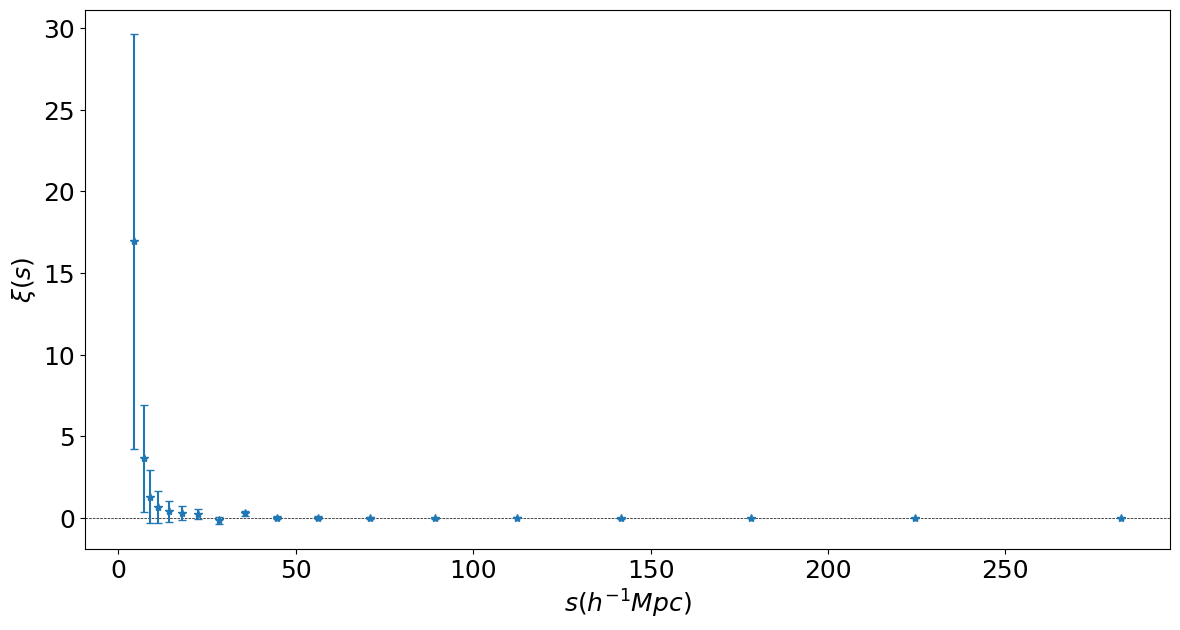

In [5]:
xi_s_array = 0
xi_s_error_array = 0
DD_count_array = 0
RR_count_array = 0
DR_count_array = 0
num_runs = 10

for i in range(num_runs):
    rand_ra, rand_dec, rand_red = make_shen_random_catalog_v3(ra_col_shen, dec_col_shen, red_col_shen, 5, 20)
    s_bins = np.logspace(start=np.log10(1.9868), stop=np.log10(314.915), num=23)
    s_mid = (s_bins[:-1] + s_bins[1:])/2
    s_mid, xi_s, xi_s_error, DD_count, RR_count, DR_count= find_xi_s(ra_col_shen, dec_col_shen, red_col_shen, s_bins, file_name="temp_shen.txt", rand_ra=rand_ra, rand_dec=rand_dec,\
                            rand_red=rand_red, ret_result=True)
    plt.close()

    xi_s_array += xi_s/num_runs
    xi_s_error_array += xi_s_error/num_runs
    DD_count_array += DD_count/num_runs
    RR_count_array += RR_count/num_runs
    DR_count_array += DR_count/num_runs

mpl.rcParams['font.size'] = 18
fign, axn = plt.subplots(figsize=(14,7))
axn.axhline(0, ls = '--', lw = 0.5, c = 'black')

axn.errorbar(s_mid, xi_s_array, xi_s_error_array, fmt='*', capsize=3)
axn.set_ylabel(r'$\xi(s)$')
axn.set_xlabel(r'$s (h^{-1}Mpc)$')

In [ ]:
pos = ~xi_s.mask
xi_val = np.array(xi_s[pos])
s_val = np.array(s_mid[pos])
xi_err = np.array(xi_s_error[pos])

initial = np.array([100.0, 2.0])
ndim = len(initial)

nwalkers = 100

data = (s_val[2:], xi_val[2:], xi_err[2:])

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
sampler.run_mcmc(p0, 1000);
sampler.reset()

sampler.run_mcmc(p0, 10000);

samples = sampler.flatchain
print(samples.shape)

import corner
mpl.rcParams['font.size'] = 14
labels = ['s0', 'delta']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
plt.show()

In [ ]:
file = open(DP2_DIRECTORY + "Data/" + "latex_table.txt.txt", 'r')
data_here = np.genfromtxt(file) 

s_mid = data_here[:,0]
xi = data_here[:, 8]
xi_err = data_here[:, 10]

loc_here = np.where(~(np.isnan(xi) | np.isnan(xi_err)))

s_mid = s_mid[loc_here]
xi = xi[loc_here]
xi_err = xi_err[loc_here]

mpl.rcParams['font.size'] = 18
fign, axn = plt.subplots(figsize=(14,7))
axn.axhline(0, ls = '--', lw = 0.5, c = 'black')

axn.errorbar(s_mid, xi, xi_err, fmt='*', capsize=3)
axn.set_ylabel(r'$\xi(s)$')
axn.set_xlabel(r'$s (h^{-1}Mpc)$')

fit_clust = pow(s_mid/ 78.48, -2.47)
fit_clust_u = pow(s_mid/ (78.48+55.19), -2.47+1.67)
fit_clust_d = pow(s_mid/ (78.48-52.94), -2.47-1.19)

axn.plot(s_mid, fit_clust, '-', label="mcmc fit")
axn.fill_between(s_mid, fit_clust_d, fit_clust_u, color='orange', alpha=.2, label="confidence interval")
plt.legend()

## Thinking about completeness

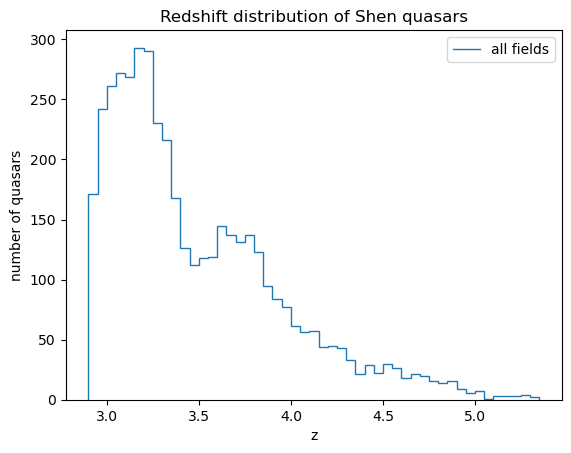

In [3]:
bins = [2.9 + i*0.05 for i in range(50)]
hist, edges = np.histogram(red_col_shen, bins=bins)
#hist_good, edges_good = np.histogram(red_col_shen_good, bins=bins)

#hist = hist/np.max(hist)
#hist_good = hist_good/np.max(hist_good)

plt.stairs(hist, edges, label="all fields")
#plt.stairs(hist_good, edges, label="good field only")
plt.title("Redshift distribution of Shen quasars")
plt.xlabel('z')
plt.ylabel('number of quasars')
plt.legend()

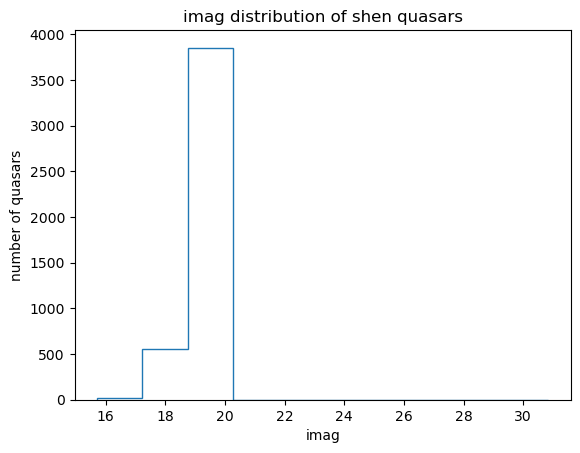

In [4]:
hist_imag, edge_imag = np.histogram(imag_col_shen)

plt.stairs(hist_imag, edge_imag)
plt.title("imag distribution of shen quasars")
plt.xlabel("imag")
plt.ylabel("number of quasars");

##### There are two quasars with imag > 21.0, which are shown below

In [5]:
print("Two imag greater than 21.0", imag_col_shen[np.where(imag_col_shen > 21.0)])
print("Max imag = ", np.max(imag_col_shen))
print("Min imag = ", np.min(imag_col_shen))
print("imag < 17 are {} quasars. Their imags are {}".format(len(np.where(imag_col_shen < 17)[0]), imag_col_shen[np.where(imag_col_shen < 17)]))

Two imag greater than 21.0 [30.84 30.74]
Max imag =  30.84
Min imag =  15.72
imag < 17 are 10 quasars. Their imags are [16.18 16.68 16.64 16.33 16.58 16.51 16.36 16.81 16.91 15.72]


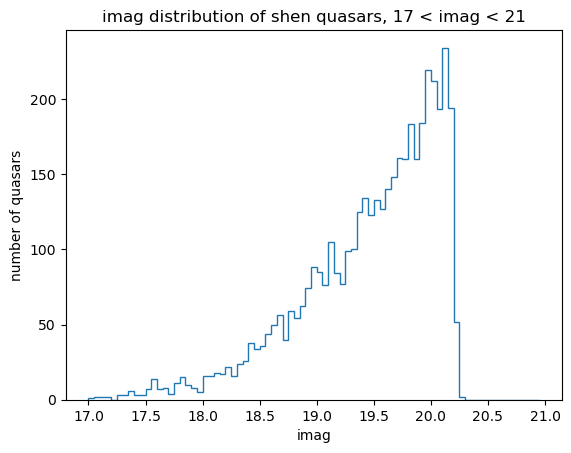

In [6]:
bins = np.arange(17.0, 21.0, 0.05)
hist_imag, edge_imag = np.histogram(imag_col_shen, bins=bins)

plt.stairs(hist_imag, edge_imag)
plt.title("imag distribution of shen quasars, 17 < imag < 21")
plt.xlabel("imag")
plt.ylabel("number of quasars");

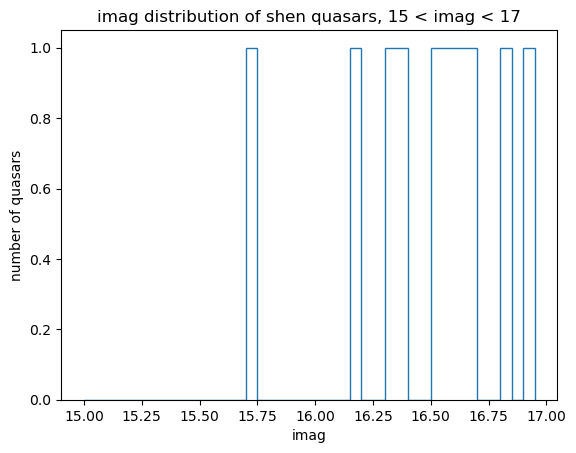

In [7]:
bins = np.arange(15.0, 17.0, 0.05)
hist_imag, edge_imag = np.histogram(imag_col_shen, bins=bins)

plt.stairs(hist_imag, edge_imag)
plt.title("imag distribution of shen quasars, 15 < imag < 17")
plt.xlabel("imag")
plt.ylabel("number of quasars");

### Completeness

In [8]:
sdss_sel_fun_file_name = DP2_DIRECTORY + 'Data/sdss_q_sel_fun_richards.dat'
sdss_sel_fun_file = open(sdss_sel_fun_file_name, 'r')
sdss_sel_fun = np.genfromtxt(sdss_sel_fun_file)

sel_fun_imag_col = sdss_sel_fun[:,0]
sel_fun_z_col = sdss_sel_fun[:,1]
sel_fun_point_col = sdss_sel_fun[:,2]
sel_fun_radio_col = sdss_sel_fun[:,3]
sel_fun_extended_col = sdss_sel_fun[:,4]

### selection function is given in the following way: 53 i magnitudes are there from 15.0 to 20.2, difference of 0.1, for each magnitude 121 z values 
# from 0.0 to 6.0 is given with difference of 0.05.

In [69]:
sel_fun_grid = np.reshape(sel_fun_point_col, (53, 121))
z_val = sel_fun_z_col[:121]
imag_val = np.reshape(sel_fun_imag_col, (53,121))[:,0]

z_val = z_val - 0.05/2
z_val = np.append(z_val, z_val[-1] + 0.05)

imag_val = imag_val - 0.1/2
imag_val = np.append(imag_val, imag_val[-1] + 0.1)

#imag_val, z_val = np.meshgrid(imag_val, z_val)

In [76]:
np.min(red_col_shen)

2.901

Text(0.5, 1.0, 'Completeness map Richard et al 2006')

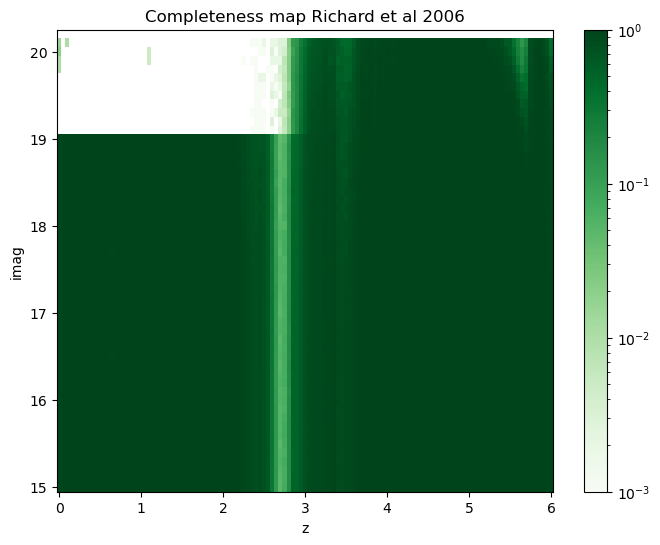

In [75]:
fig, ax = plt.subplots(figsize=(8,6))

c = ax.pcolormesh(z_val, imag_val, sel_fun_grid, cmap ='Greens', norm='log') #, vmin= 0, vmax=1)
fig.colorbar(c)
ax.set_xlabel("z")
ax.set_ylabel("imag")
ax.set_title("Completeness map Richard et al 2006")

## Limiting magnitude changes from 19.1 to 20.2 around z ~ 3.

Text(0.5, 1.0, 'Histogram of shen quasars in z and imag')

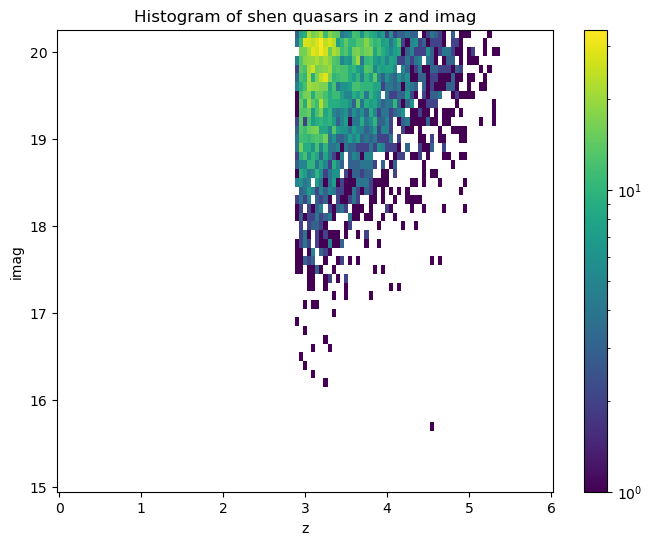

In [59]:
fig, ax = plt.subplots(figsize=(8,6))
count, xedge, yedge, im = ax.hist2d(red_col_shen, imag_col_shen, [z_val, imag_val], norm='log');
fig.colorbar(im)
plt.xlabel("z")
plt.ylabel("imag")
plt.title("Histogram of shen quasars in z and imag")

In [83]:
z_val

array([-0.025,  0.025,  0.075,  0.125,  0.175,  0.225,  0.275,  0.325,
        0.375,  0.425,  0.475,  0.525,  0.575,  0.625,  0.675,  0.725,
        0.775,  0.825,  0.875,  0.925,  0.975,  1.025,  1.075,  1.125,
        1.175,  1.225,  1.275,  1.325,  1.375,  1.425,  1.475,  1.525,
        1.575,  1.625,  1.675,  1.725,  1.775,  1.825,  1.875,  1.925,
        1.975,  2.025,  2.075,  2.125,  2.175,  2.225,  2.275,  2.325,
        2.375,  2.425,  2.475,  2.525,  2.575,  2.625,  2.675,  2.725,
        2.775,  2.825,  2.875,  2.925,  2.975,  3.025,  3.075,  3.125,
        3.175,  3.225,  3.275,  3.325,  3.375,  3.425,  3.475,  3.525,
        3.575,  3.625,  3.675,  3.725,  3.775,  3.825,  3.875,  3.925,
        3.975,  4.025,  4.075,  4.125,  4.175,  4.225,  4.275,  4.325,
        4.375,  4.425,  4.475,  4.525,  4.575,  4.625,  4.675,  4.725,
        4.775,  4.825,  4.875,  4.925,  4.975,  5.025,  5.075,  5.125,
        5.175,  5.225,  5.275,  5.325,  5.375,  5.425,  5.475,  5.525,
      

In [103]:
ind = np.where(z_val == 2.875)[0][0]

z_val_reduced = z_val[ind:]
sel_fun_grid_reduced = sel_fun_grid[:-1,ind:]
imag_val_reduced = imag_val[:-1]

Text(0.5, 1.0, 'Completeness map Richard et al 2006')

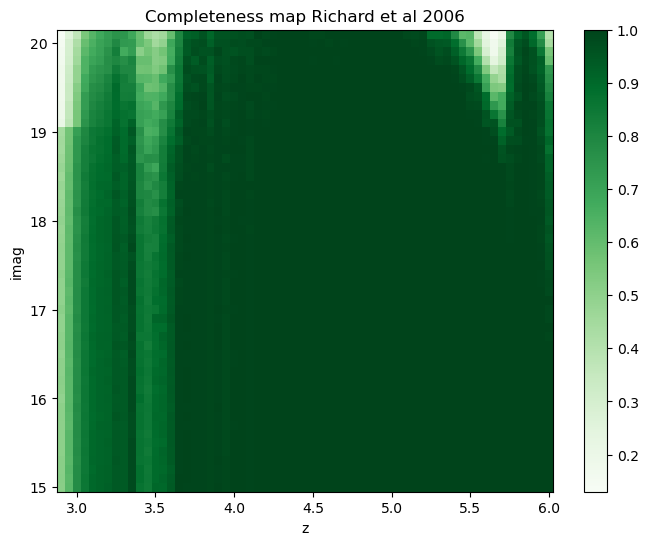

In [108]:
fig, ax = plt.subplots(figsize=(8,6))

c = ax.pcolormesh(z_val_reduced, imag_val_reduced, sel_fun_grid_reduced, cmap ='Greens') #, vmin= 0, vmax=1)
fig.colorbar(c)
ax.set_xlabel("z")
ax.set_ylabel("imag")
ax.set_title("Completeness map Richard et al 2006")

Text(0.5, 1.0, 'Histogram of shen quasars in z and imag')

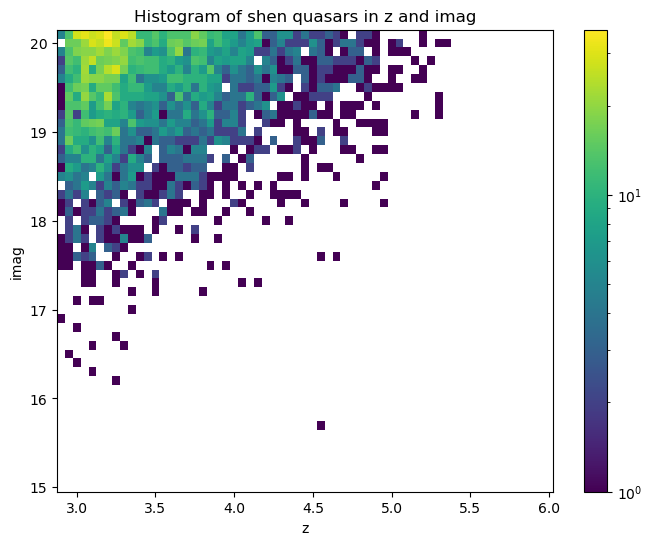

In [109]:
fig, ax = plt.subplots(figsize=(8,6))
count, xedge, yedge, im = ax.hist2d(red_col_shen, imag_col_shen, [z_val_reduced, imag_val_reduced], norm='log');
fig.colorbar(im)
plt.xlabel("z")
plt.ylabel("imag")
plt.title("Histogram of shen quasars in z and imag")

In [111]:
new_count = count/sel_fun_grid_reduced.transpose()

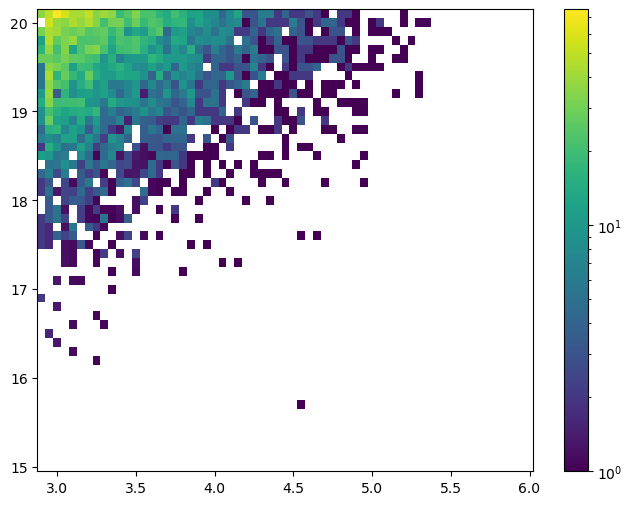

In [115]:
fig, ax = plt.subplots(figsize=(8,6))

c = ax.pcolormesh(z_val_reduced, imag_val_reduced, new_count.transpose(), norm='log') #, vmin= 0, vmax=1)
fig.colorbar(c)

In [119]:
red_dist_no_compl = np.sum(count, axis=1)
red_dist_yes_compl = np.sum(new_count, axis=1)

Number of quasars before completeness correction = 4176.0


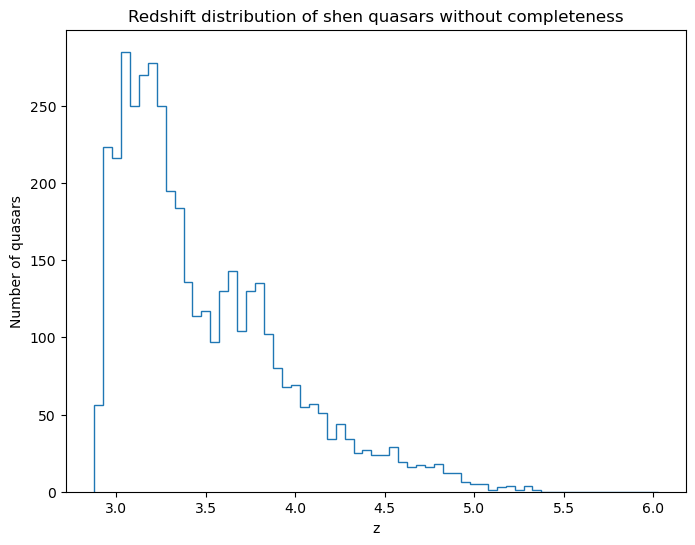

In [130]:
fig, ax = plt.subplots(figsize=(8,6))
ax.stairs(red_dist_no_compl, z_val_reduced)
ax.set_xlabel("z")
ax.set_ylabel("Number of quasars")
ax.set_title("Redshift distribution of shen quasars without completeness")
print("Number of quasars before completeness correction =", np.round(np.sum(red_dist_no_compl),2))

Number of quasars when completeness corrected = 5784.96


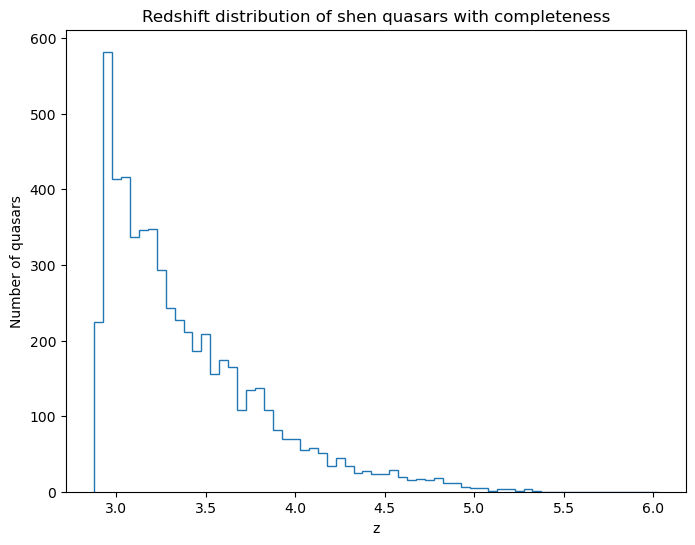

In [129]:
fig, ax = plt.subplots(figsize=(8,6))
ax.stairs(red_dist_yes_compl, z_val_reduced)
ax.set_xlabel("z")
ax.set_ylabel("Number of quasars")
ax.set_title('Redshift distribution of shen quasars with completeness');
print("Number of quasars when completeness corrected =", np.round(np.sum(red_dist_yes_compl),2))